In [1]:
from google.colab import output, drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install -U insightface
!pip install onnxruntime-gpu==1.8.0
output.clear()

In [2]:
!gdown --id 1kXvXZ103G0N44xPo6PsPN1RlsS0rNzj1
!unzip benchmark.zip
output.clear()

In [3]:
import cv2
import numpy as np
import torch
from torch import nn
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, accuracy_score, RocCurveDisplay

In [4]:
__all__ = ['iresnet18', 'iresnet34', 'iresnet50', 'iresnet100', 'iresnet200']


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=dilation,
                     groups=groups,
                     bias=False,
                     dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)


class IBasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1):
        super(IBasicBlock, self).__init__()
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        self.bn1 = nn.BatchNorm2d(inplanes, eps=1e-05,)
        self.conv1 = conv3x3(inplanes, planes)
        self.bn2 = nn.BatchNorm2d(planes, eps=1e-05,)
        self.prelu = nn.PReLU(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn3 = nn.BatchNorm2d(planes, eps=1e-05,)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.bn1(x)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.prelu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        return out


class IResNet(nn.Module):
    fc_scale = 7 * 7
    def __init__(self,
                 block, layers, dropout=0, num_features=512, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None, fp16=False):
        super(IResNet, self).__init__()
        self.fp16 = fp16
        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes, eps=1e-05)
        self.prelu = nn.PReLU(self.inplanes)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=2)
        self.layer2 = self._make_layer(block,
                                       128,
                                       layers[1],
                                       stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block,
                                       256,
                                       layers[2],
                                       stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block,
                                       512,
                                       layers[3],
                                       stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.bn2 = nn.BatchNorm2d(512 * block.expansion, eps=1e-05,)
        self.dropout = nn.Dropout(p=dropout, inplace=True)
        self.fc = nn.Linear(512 * block.expansion * self.fc_scale, num_features)
        self.features = nn.BatchNorm1d(num_features, eps=1e-05)
        nn.init.constant_(self.features.weight, 1.0)
        self.features.weight.requires_grad = False

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0, 0.1)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, IBasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion, eps=1e-05, ),
            )
        layers = []
        layers.append(
            block(self.inplanes, planes, stride, downsample, self.groups,
                  self.base_width, previous_dilation))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(self.inplanes,
                      planes,
                      groups=self.groups,
                      base_width=self.base_width,
                      dilation=self.dilation))

        return nn.Sequential(*layers)

    def forward(self, x):
        with torch.cuda.amp.autocast(self.fp16):
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.prelu(x)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)
            x = self.bn2(x)
            x = torch.flatten(x, 1)
            x = self.dropout(x)
        x = self.fc(x.float() if self.fp16 else x)
        x = self.features(x)
        return x


def _iresnet(arch, block, layers, pretrained, progress, **kwargs):
    model = IResNet(block, layers, **kwargs)
    if pretrained:
        raise ValueError()
    return model


def iresnet18(pretrained=False, progress=True, **kwargs):
    return _iresnet('iresnet18', IBasicBlock, [2, 2, 2, 2], pretrained,
                    progress, **kwargs)


def iresnet34(pretrained=False, progress=True, **kwargs):
    return _iresnet('iresnet34', IBasicBlock, [3, 4, 6, 3], pretrained,
                    progress, **kwargs)


def iresnet50(pretrained=False, progress=True, **kwargs):
    return _iresnet('iresnet50', IBasicBlock, [3, 4, 14, 3], pretrained,
                    progress, **kwargs)


def iresnet100(pretrained=False, progress=True, **kwargs):
    return _iresnet('iresnet100', IBasicBlock, [3, 13, 30, 3], pretrained,
                    progress, **kwargs)


def iresnet200(pretrained=False, progress=True, **kwargs):
    return _iresnet('iresnet200', IBasicBlock, [6, 26, 60, 6], pretrained,
                    progress, **kwargs)


In [5]:
def get_model(name, **kwargs):
    # resnet
    if name == "r18":
        return iresnet18(False, **kwargs)
    elif name == "r34":
        return iresnet34(False, **kwargs)
    elif name == "r50":
        return iresnet50(False, **kwargs)
    elif name == "r100":
        return iresnet100(False, **kwargs)
    elif name == "r200":
        return iresnet200(False, **kwargs)
    else:
        raise ValueError()

In [6]:
args = {"sqrt" : False,
        "manual" : False}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
name = "r34"
weight = "/content/drive/MyDrive/face_recog/backbone.pth"
net = get_model(name, fp16=False)
net.load_state_dict(torch.load(weight))
net = net.to(device)

In [10]:
def read_imgs(imgs):
    res = []
    for img in imgs:
        if img is None:
            img = np.random.randint(0, 255, size=(112, 112, 3), dtype=np.uint8)
        else:
            img = cv2.imread(img)
            img = cv2.resize(img, (112, 112))

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.transpose(img, (2, 0, 1))
        img = torch.from_numpy(img).float()
        img.div_(255).sub_(0.5).div_(0.5)
        res.append(img)
    return torch.stack(res).to(device)

@torch.no_grad()
def save_feat(imgs):
    imgs_arr = read_imgs(imgs)
    net.eval()
    feat = net(imgs_arr).cpu().numpy()
    return {key:val for key,val in zip(imgs, feat)}

def Var(x:np.ndarray):
    n = len(x)
    x_hat = x.mean()
    return n * np.sum((x-x_hat)**2)

def NED(u,v, epsilon=1e-8):
    ned = 0.5 * Var(u-v) / (Var(u) + Var(v) + epsilon)
    return 1 - ned**0.5 if args["sqrt"] else 1 - ned

def get_pairs(pair_path):
    df = pd.read_csv(pair_path)
    return df.values

def find_th(fpr, tpr, threshold):
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return roc_t['threshold'].values

def eval(pairs:np.ndarray, threshold:int=0.6):
    start = time.time()
    imgs_1 = pairs[:,0].copy()
    imgs_2 = pairs[:,1].copy()
    labels = pairs[:,2].copy().astype(int)

    feats_1 = save_feat(np.unique(imgs_1).tolist())
    feats_2 = save_feat(np.unique(imgs_2).tolist())

    dist = np.array([NED(feats_1[x], feats_2[y]) for x,y in zip(imgs_1, imgs_2)])
    assert len(dist) == len(labels)
    # threshold = np.repeat(threshold, len(dist))
    # pred = np.greater_equal(dist, threshold).astype(int)

    if args["manual"]:
        _ = get_metrics(labels, dist)
    else:
        fpr, tpr, thresh = roc_curve(labels, dist)
        best_th = find_th(fpr, tpr, thresh)
        # print(tpr)
        # print("==================")
        # print(fpr)
        # print("==================")
        # print(accuracy_score(labels, pred))
        for i in [0.1, 0.01, 0.001]:
            print("TPR@FPR {}: {}".format(i, np.interp(i, fpr, tpr)))
        print("Best threshold : {}".format(best_th))
    RocCurveDisplay.from_predictions(labels, dist)
    plt.show()
    print("Done in : {}".format(time.time()-start))

TPR@FPR 0.1: 0.9491525423728814
TPR@FPR 0.01: 0.8983050847457628
TPR@FPR 0.001: 0.7966101694915254
Best threshold : [0.65627661]


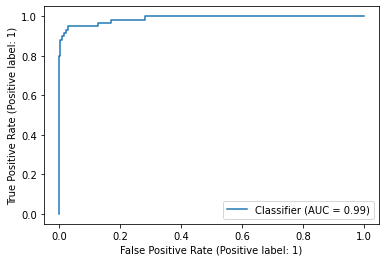

Done in : 1.1526646614074707


In [11]:
pair_path = "/content/pairing_kris_foto_lama.csv"
eval(get_pairs(pair_path))

TPR@FPR 0.1: 0.9830508474576272
TPR@FPR 0.01: 0.8983050847457628
TPR@FPR 0.001: 0.8305084745762712
Best threshold : [0.65034412]


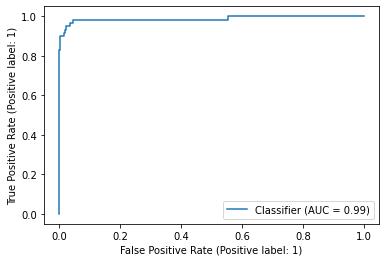

Done in : 0.9710507392883301


In [12]:
pair_path = "/content/pairing_kris_foto_paling_lama.csv"
eval(get_pairs(pair_path))